# Random Forest Pipeline

This notebook will build a Random Forest Classifier on the Statcast data. We will tune hyperparmeters to boost performance, and then apply interpretability methods, LIME and SHAP to the results. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
from sklearn.ensemble import RandomForestClassifier
from data_import import preprocess_data
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, validation_curve
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import make_pipeline, Pipeline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from Evaluation import *

In [2]:
#load in the preprocessed data
data = preprocess_data('Statcast_data.csv')
target = data['description']
#filter out 'player_name'; will not use as a feature
#and filter out the target
data = data.iloc[:, :-2]
data.head()



/home/jupyter-khickey550/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


,release_speed,release_spin_rate,release_pos_x,release_pos_y,release_pos_z,pfx_x,pfx_z,vx0,vy0,vz0,...,pitch_name_Changeup,pitch_name_Curveball,pitch_name_Cutter,pitch_name_Sinker,pitch_name_Slider,pitch_name_Split Finger,pitch_name_nan,p_throws_L,p_throws_R,p_throws_nan
0,1.073523,0.225683,2.080234,-0.016458,-1.073886,2.119752,-0.279650,-1.984984,-1.064687,1.276245,...,0,0,0,0,0,0,0,1,0,0
1,1.340953,0.258210,2.033107,-0.393337,-0.823324,1.228740,0.483185,-1.856961,-1.349626,0.535466,...,0,0,0,0,0,0,0,1,0,0
2,-1.316632,0.898992,2.124057,1.138366,-1.320666,-0.982587,-1.009283,-1.006819,1.330334,1.589316,...,0,0,0,0,1,0,0,1,0,0
3,1.257381,0.274474,2.013077,-0.965694,-1.152964,1.662236,0.401776,-2.347235,-1.209132,-0.252616,...,0,0,0,0,0,0,0,1,0,0
4,1.307524,0.625765,2.099451,-0.293616,-1.431626,1.619067,0.139219,-2.665304,-1.265463,0.268337,...,0,0,0,0,0,0,0,1,0,0


In [3]:
#first, create a hold-out set as a final evaluation set
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 777, test_size = .2)

#instatiate a vanilla Random Forest Classifier
forest = RandomForestClassifier()

## Build a pipeline

#### Random Oversampler and the vannia Random Forest.

In [4]:
forest_pipe = Pipeline(steps= [
    ('sampler', RandomOverSampler(ratio = 1, random_state = 777)),
    ('clf', forest)
                            ])

In [5]:
results = eval_model(forest_pipe, X_train, y_train, cv = 3)

Mean train_accuracy Value: 0.9922976105583784
train_accuracy scores: [0.99209365 0.99238497 0.9924142 ]

Mean test_accuracy Value: 0.6304309716281361
test_accuracy scores: [0.63038351 0.63182877 0.62908064]

Mean train_f1 Value: 0.9878606814772065
train_f1 scores: [0.98754787 0.98799936 0.98803482]

Mean test_f1 Value: 0.23552676687878424
test_f1 scores: [0.23697024 0.23491679 0.23469326]

Mean train_roc_auc Value: 0.9995785316786355
train_roc_auc scores: [0.99957471 0.99960839 0.99955249]

Mean test_roc_auc Value: 0.5270518625632508
test_roc_auc scores: [0.53019902 0.52681824 0.52413832]

dict_keys(['memory', 'steps', 'sampler', 'clf', 'sampler__random_state', 'sampler__ratio', 'sampler__return_indices', 'sampler__sampling_strategy', 'clf__bootstrap', 'clf__class_weight', 'clf__criterion', 'clf__max_depth', 'clf__max_features', 'clf__max_leaf_nodes', 'clf__min_impurity_decrease', 'clf__min_impurity_split', 'clf__min_samples_leaf', 'clf__min_samples_split', 'clf__min_weight_fraction_le

## Analysis

Model is most likely overfitting. Let's check to make sure.

<module 'matplotlib.pyplot' from '/opt/tljh/user/lib/python3.6/site-packages/matplotlib/pyplot.py'>

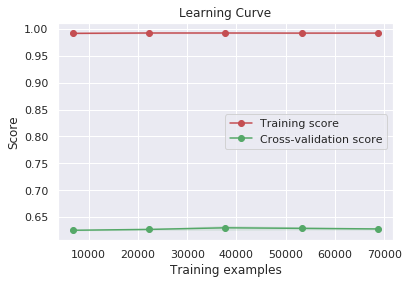

In [16]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    from sklearn.model_selection import learning_curve
    from sklearn.model_selection import ShuffleSplit
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid(b=True)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(forest_pipe, title = "Learning Curve",
                    X = X_train, y = y_train, cv = 3, n_jobs = -1)

## Tuning

Here we will tune the model to try and improve results.

Let's try a bit of regularization to see what happens




In [15]:
import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

forest_search_space = {
    'clf': Categorical([RandomForestClassifier()]),
    'clf__n_estimators': Integer(1, 1000),
    'clf__criterion': Categorical(['gini', 'entropy']),
    'clf__max_depth': Real(1e1, 1e6, 'log-uniform'),
    'clf__min_samples_split': Real(1e-6, 1e-1, 'log-uniform'),
    'clf__min_samples_leaf': Real(1e-6, 5e-1, 'log-uniform'),
    'clf__max_features': Integer(1,20)
                        }

bayes_cv_tuner = BayesSearchCV(estimator = forest_pipe, 
                              scoring='accuracy',
                              search_spaces=forest_search_space, 
                               verbose = 1, random_state=777,
                               n_jobs = -1
                              )
#helper function to print results
def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
            

In [16]:
results = bayes_cv_tuner.fit(X_train.values, y_train.values, callback = status_print)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Model #1
Best ROC-AUC: 0.3196
Best params: {'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=273740.53638664953, max_features=3,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.37400355603033164,
            min_samples_split=0.005717634227907649,
            min_weight_fraction_leaf=0.0, n_estimators=310, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), 'clf__criterion': 'gini', 'clf__max_depth': 273740.53638664953, 'clf__max_features': 3, 'clf__min_samples_leaf': 0.37400355603033164, 'clf__min_samples_split': 0.005717634227907649, 'clf__n_estimators': 310}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Model #2
Best ROC-AUC: 0.4974
Best params: {'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=77.28980653564535, max_features=17,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.020067617910684534,
            min_samples_split=0.00016791968501808307,
            min_weight_fraction_leaf=0.0, n_estimators=410, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), 'clf__criterion': 'entropy', 'clf__max_depth': 77.28980653564535, 'clf__max_features': 17, 'clf__min_samples_leaf': 0.020067617910684534, 'clf__min_samples_split': 0.00016791968501808307, 'clf__n_estimators': 410}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


KeyboardInterrupt: 